# Sec Recon Network

In [18]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import combinations

In [2]:
# Generate secrecon dataframe
secrecon = pd.read_excel("Input/working_secRecon.xlsx", sheet_name="master_curated_09202021")
unprocesses = pd.read_excel("Input/uniqueProcesses_finalOntology.xlsx", sheet_name="Final ontology")

In [3]:
#Generate dictionaries

gene_dict = {}
for index, row in secrecon.iterrows():
    gene = row['GENE SYMBOL']
    # Grab the processes and filter out any NaN values
    processes = row[['Process 1', 'Process 2', 'Process 3', 'Process 4', 'Process 5',
                     'Process 6', 'Process 7', 'Process 8', 'Process 9', 'Process 10']].dropna().tolist()
    gene_dict[gene] = processes

In [4]:
# Process Dict
process_dict = {}

for index, row in unprocesses.iterrows():
    system = row['System']
    subsystem = row['Subsystem'] if pd.notna(row['Subsystem']) else None
    process = row['Process'] if pd.notna(row['Process']) else None
    subprocess = row['Subprocess'] if pd.notna(row['Subprocess']) else None
    
    if system not in process_dict:
        process_dict[system] = []
        
    process_dict[system].append({k: v for k, v in {
        'Subsystem': subsystem,
        'Process': process,
        'Subprocess': subprocess
    }.items() if v is not None})

In [5]:
# Colouring the nodes according the systems
category_colors = {
    'Translocation': 'blue',
    'Protein conformation': 'red',
    'Post-translational modifications': 'green',
    'Proteostasis': 'purple',
    'Vesicle trafficking': 'yellow'
}

In [11]:
for category, processes in process_dict.items():
    print(flatten_processes(category,processes))
    print(category)

['Co-translational translocation', 'Translocation', 'Post-translational translocation', 'Translocation', 'TRC pathway', 'Translocation', 'Translocation']
Translocation
['Protein folding', 'Protein conformation', 'Multimerization', 'Protein conformation', 'Protein conformation']
Protein conformation
['Lipidation', 'Post-translational modifications', 'Glycosylation', 'N-glycan', 'Post-translational modifications', 'Glycosylation', 'O-glycan', 'O-glycan mucin', 'Post-translational modifications', 'Glycosylation', 'O-glycan', 'O-glycan not-mucin', 'Post-translational modifications', 'Glycosylation', 'Glycosaminoglycan', 'Chondroitin sulfate', 'Post-translational modifications', 'Glycosylation', 'Glycosaminoglycan', 'Dermatan sulfate', 'Post-translational modifications', 'Glycosylation', 'Glycosaminoglycan', 'Heparan sulfate', 'Post-translational modifications', 'Glycosylation', 'Glycosaminoglycan', 'Keratan sulfate', 'Post-translational modifications', 'Glycosylation', 'Glycosaminoglycan',

In [12]:
def get_gene_color(gene, gene_dict, process_dict, category_colors):
    for category, processes in process_dict.items():
        if any(process in gene_dict.get(gene, []) for process in flatten_processes(category, processes)):
            return category_colors.get(category, 'black')  # Use black as default color
    return 'black'

In [13]:
def flatten_processes(category, process_list):
    flat_list = []
    for process in process_list:
        if isinstance(process, dict):
            flat_list.extend(flatten_processes(category, list(process.values())))
        elif isinstance(process, list):
            flat_list.extend(flatten_processes(category, process))
        else:
            flat_list.append(process)
            
    flat_list.append(category)
    
    return flat_list

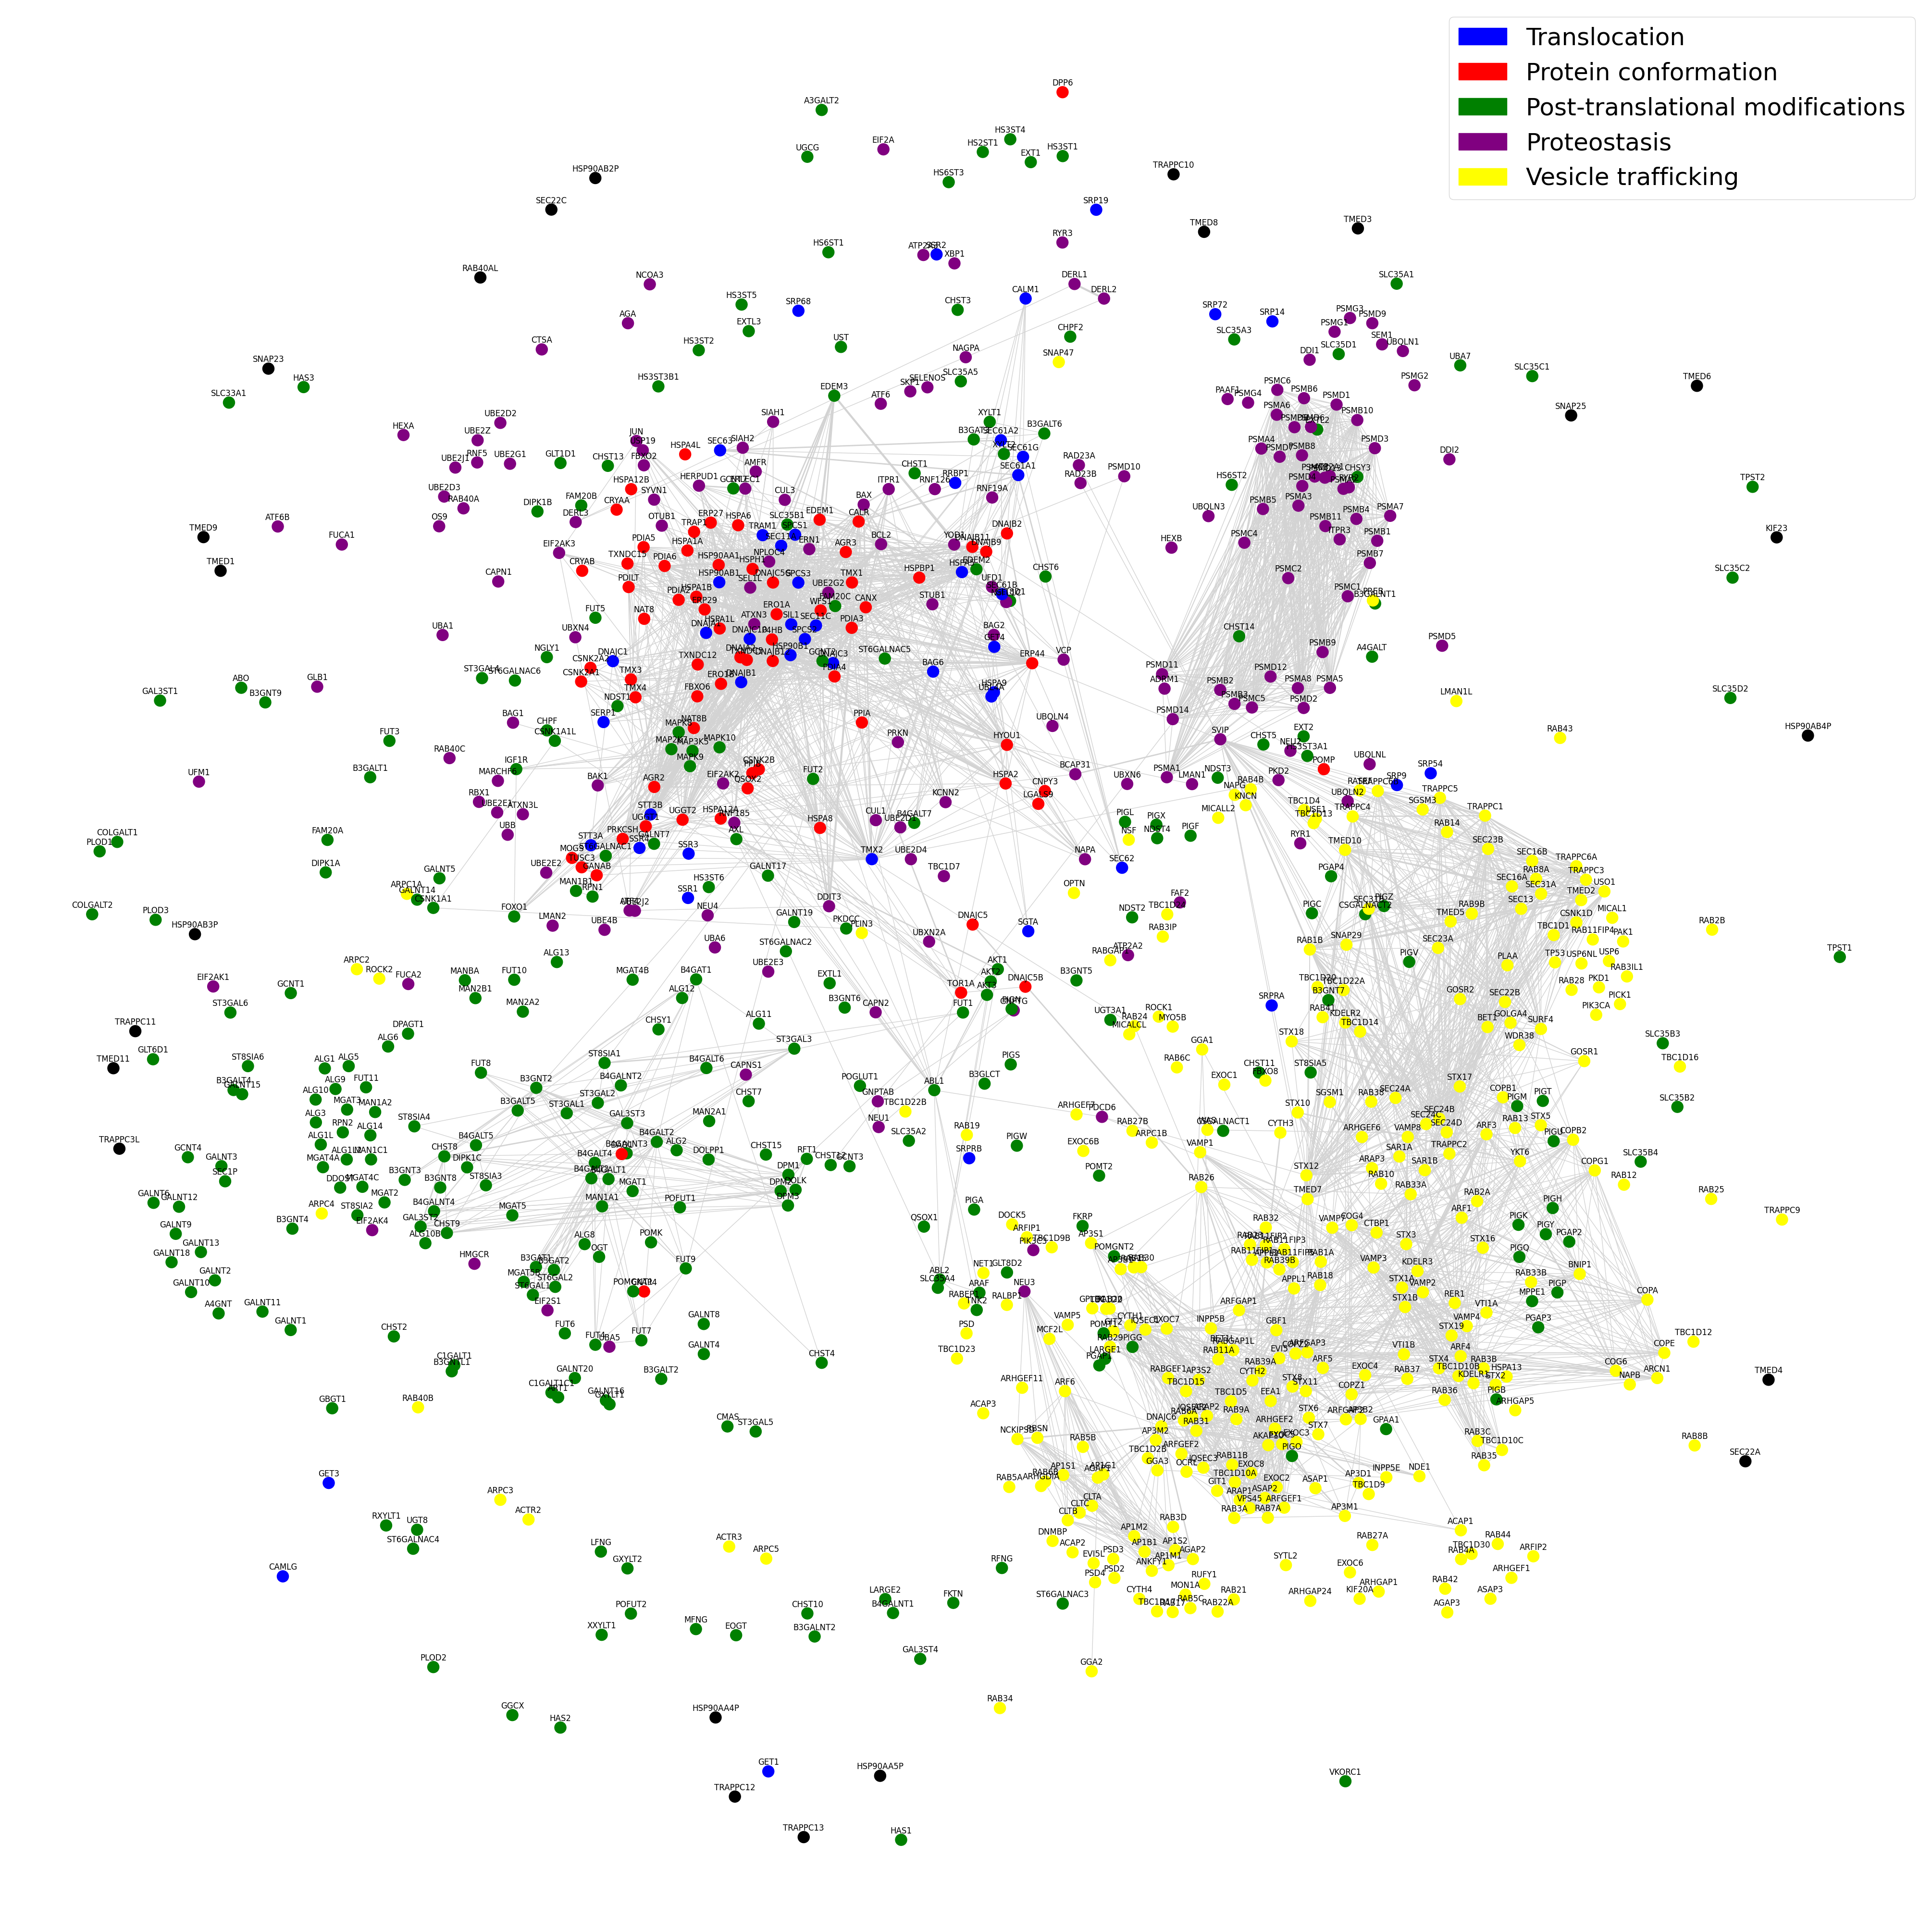

In [23]:
# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Adding edges
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]).intersection(gene_dict[gene2]))
    if shared_processes > 0:
        G.add_edge(gene1, gene2, weight=shared_processes)

# Color code node according to the System they belong to
node_colors = [get_gene_color(node, gene_dict, process_dict, category_colors) for node in G.nodes]

# Draw the graph
plt.figure(figsize=(40, 40))
pos = nx.spring_layout(G, seed=42, iterations=50, k=0.6)   # Set fixed position for nodes
# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 1]

nx.draw(G, pos, node_color=node_colors, edgelist=edgelist, node_size=300, edge_color='lightgrey', 
        width=[G[u][v]['weight'] for u, v in G.edges()])  # Set edge width to be proportional to the shared processes

# labels
label_pos = {node: (coords[0], coords[1] + 0.01) for node, coords in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=12) 

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 36}) 

plt.show()